# Лабораторная работа №6

Прогнозирование медианной цены недвижимости в Бостоне (`MEDV`) по признакам датасета `boston.csv`.

В отчете приведены исходные коды и результаты выполнения всех пунктов задания.

In [10]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

TARGET = 'MEDV'

## 1. Загрузка данных

In [11]:
df = pd.read_csv('boston.csv')
print('Форма датасета:', df.shape)
display(df.head())

Форма датасета: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 2. Проверка типов данных

In [12]:
display(df.dtypes)

# На всякий случай приводим все столбцы к числовому типу.
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print('\nТипы после приведения:')
display(df.dtypes)

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object


Типы после приведения:


CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

## 3. Проверка и обработка пропусков

In [13]:
missing_before = df.isna().sum().sort_values(ascending=False)
print('Пропуски до заполнения:')
display(missing_before[missing_before > 0])

# Заполняем пропуски медианой по столбцу.
if df.isna().sum().sum() > 0:
    df = df.fillna(df.median(numeric_only=True))

missing_after = df.isna().sum().sum()
print('Суммарное число пропусков после заполнения:', int(missing_after))

Пропуски до заполнения:


Series([], dtype: int64)

Суммарное число пропусков после заполнения: 0


## 4. Корреляционная матрица

In [14]:
corr = df.corr(numeric_only=True)
display(corr.round(3))

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,-0.385,0.456,-0.388
ZN,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,0.176,-0.413,0.360
INDUS,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,-0.357,0.604,-0.484
CHAS,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,0.049,-0.054,0.175
NOX,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,-0.380,0.591,-0.427
RM,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,0.128,-0.614,0.695
AGE,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,-0.274,0.602,-0.377
DIS,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,0.292,-0.497,0.250
RAD,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,-0.444,0.489,-0.382
TAX,0.583,-0.315,0.721,-0.036,0.668,-0.292,0.506,-0.534,0.910,1.000,0.461,-0.442,0.544,-0.469


## 5. Heatmap корреляций

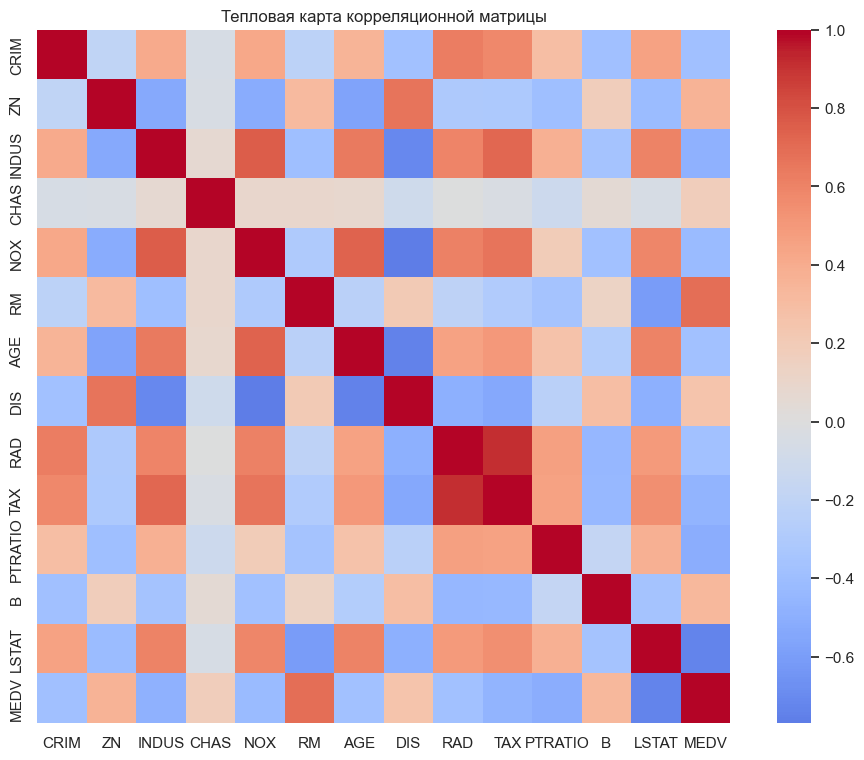

In [15]:
plt.figure(figsize=(12, 9))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True)
plt.title('Тепловая карта корреляционной матрицы')
plt.show()

## 6. Выбор 4-6 признаков с наибольшей корреляцией с MEDV

In [16]:
target_corr = corr[TARGET].drop(TARGET).sort_values(key=lambda s: s.abs(), ascending=False)
display(target_corr.to_frame('corr_with_MEDV'))

# Берем 5 самых связанных с целевой переменной признаков.
selected_features = target_corr.head(5).index.tolist()
print('Выбранные признаки:', selected_features)

,corr_with_MEDV
LSTAT,-0.737663
RM,0.695360
PTRATIO,-0.507787
INDUS,-0.483725
TAX,-0.468536
NOX,-0.427321
CRIM,-0.388305
RAD,-0.381626
AGE,-0.376955
ZN,0.360445


Выбранные признаки: ['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX']


## 7. Диаграммы рассеяния для выбранных признаков

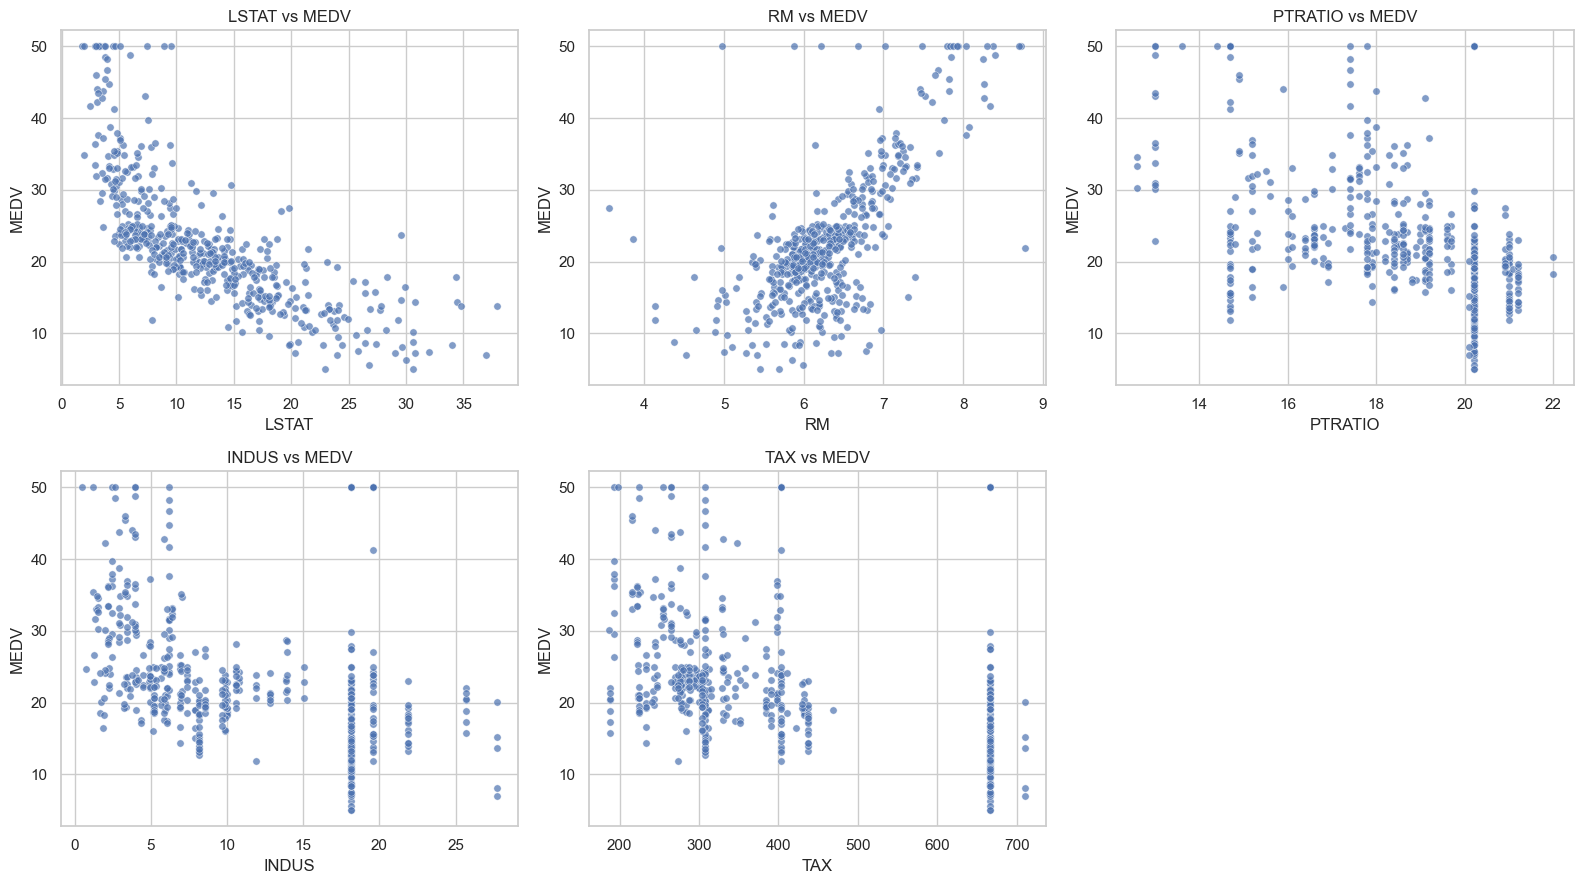

In [17]:
n = len(selected_features)
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.scatterplot(data=df, x=feature, y=TARGET, ax=axes[i], s=28, alpha=0.7)
    axes[i].set_title(f'{feature} vs {TARGET}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 8. Уточнение набора признаков после визуальной проверки

In [18]:
# Формализуем визуальную проверку: оставляем признаки с |corr| >= 0.30.
filtered_features = [f for f in selected_features if abs(target_corr[f]) >= 0.30]

# По условию должно остаться минимум 3 признака.
if len(filtered_features) < 3:
    filtered_features = selected_features[:3]

print('Итоговые признаки для моделирования:', filtered_features)

Итоговые признаки для моделирования: ['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX']


## 9-10. Формирование X, y и разбиение 80/20

In [19]:
X = df[filtered_features]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print('Train:', X_train.shape, y_train.shape)
print('Test :', X_test.shape, y_test.shape)

Train: (404, 5) (404,)
Test : (102, 5) (102,)


## 11-13. Линейная регрессия, прогнозы, R2 и RMSE

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred_train_lin = lin_reg.predict(X_train)
pred_test_lin = lin_reg.predict(X_test)

lin_metrics = {
    'model': 'LinearRegression',
    'R2_train': r2_score(y_train, pred_train_lin),
    'RMSE_train': root_mean_squared_error(y_train, pred_train_lin),
    'R2_test': r2_score(y_test, pred_test_lin),
    'RMSE_test': root_mean_squared_error(y_test, pred_test_lin)
}

pd.DataFrame([lin_metrics])

,model,R2_train,RMSE_train,R2_test,RMSE_test
0,LinearRegression,0.690258,5.187326,0.619668,5.281208


## 14. Boxplot MEDV и определение выбросов

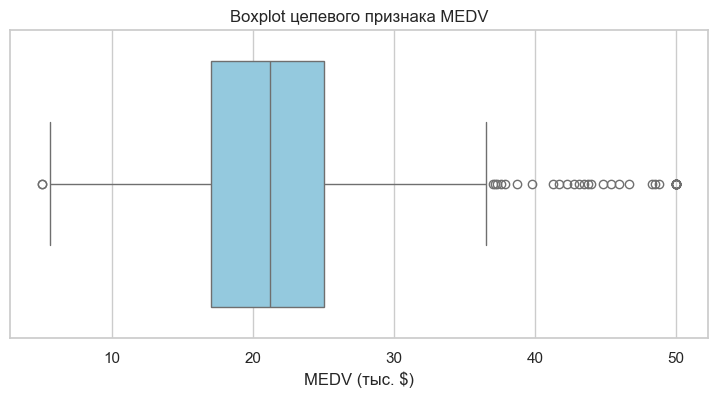

Границы выбросов по IQR: [5.062, 36.963]
Количество выбросов: 40
Уникальные значения выбросов (первые 20):
[ 5.  37.  37.2 37.3 37.6 37.9 38.7 39.8 41.3 41.7 42.3 42.8 43.1 43.5
 43.8 44.  44.8 45.4 46.  46.7]


In [21]:
plt.figure(figsize=(9, 4))
sns.boxplot(x=df[TARGET], color='skyblue')
plt.title('Boxplot целевого признака MEDV')
plt.xlabel('MEDV (тыс. $)')
plt.show()

q1 = df[TARGET].quantile(0.25)
q3 = df[TARGET].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers_mask = (df[TARGET] < lower) | (df[TARGET] > upper)
outliers = df.loc[outliers_mask, TARGET]

print(f'Границы выбросов по IQR: [{lower:.3f}, {upper:.3f}]')
print('Количество выбросов:', int(outliers_mask.sum()))
print('Уникальные значения выбросов (первые 20):')
print(np.sort(outliers.unique())[:20])

## 15. Переобучение после удаления выбросов

In [22]:
df_wo = df.loc[~outliers_mask].copy()

X_wo = df_wo[filtered_features]
y_wo = df_wo[TARGET]

X_train_wo, X_test_wo, y_train_wo, y_test_wo = train_test_split(
    X_wo, y_wo, test_size=0.2, random_state=42, shuffle=True
)

lin_reg_wo = LinearRegression()
lin_reg_wo.fit(X_train_wo, y_train_wo)

pred_train_lin_wo = lin_reg_wo.predict(X_train_wo)
pred_test_lin_wo = lin_reg_wo.predict(X_test_wo)

lin_wo_metrics = {
    'model': 'LinearRegression_without_outliers',
    'R2_train': r2_score(y_train_wo, pred_train_lin_wo),
    'RMSE_train': root_mean_squared_error(y_train_wo, pred_train_lin_wo),
    'R2_test': r2_score(y_test_wo, pred_test_lin_wo),
    'RMSE_test': root_mean_squared_error(y_test_wo, pred_test_lin_wo)
}

comparison_15 = pd.DataFrame([lin_metrics, lin_wo_metrics])
display(comparison_15)

print('Изменение после удаления выбросов:')
print('R2_test  :', round(lin_wo_metrics['R2_test'] - lin_metrics['R2_test'], 4))
print('RMSE_test:', round(lin_wo_metrics['RMSE_test'] - lin_metrics['RMSE_test'], 4))

,model,R2_train,RMSE_train,R2_test,RMSE_test
0,LinearRegression,0.690258,5.187326,0.619668,5.281208
1,LinearRegression_without_outliers,0.703700,3.522346,0.689916,3.526919


Изменение после удаления выбросов:
R2_test  : 0.0702
RMSE_test: -1.7543


## 16. Ridge-регрессия

In [23]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

pred_train_ridge = ridge.predict(X_train)
pred_test_ridge = ridge.predict(X_test)

ridge_metrics = {
    'model': 'Ridge(alpha=1.0)',
    'R2_train': r2_score(y_train, pred_train_ridge),
    'RMSE_train': root_mean_squared_error(y_train, pred_train_ridge),
    'R2_test': r2_score(y_test, pred_test_ridge),
    'RMSE_test': root_mean_squared_error(y_test, pred_test_ridge)
}

pd.DataFrame([ridge_metrics])

,model,R2_train,RMSE_train,R2_test,RMSE_test
0,Ridge(alpha=1.0),0.690252,5.187376,0.620452,5.275767


## 17. Полиномиальная регрессия (степень 3)

In [24]:
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('lin', LinearRegression())
])

poly_model.fit(X_train, y_train)

pred_train_poly = poly_model.predict(X_train)
pred_test_poly = poly_model.predict(X_test)

poly_metrics = {
    'model': 'PolynomialRegression(degree=3)',
    'R2_train': r2_score(y_train, pred_train_poly),
    'RMSE_train': root_mean_squared_error(y_train, pred_train_poly),
    'R2_test': r2_score(y_test, pred_test_poly),
    'RMSE_test': root_mean_squared_error(y_test, pred_test_poly)
}

pd.DataFrame([poly_metrics])

,model,R2_train,RMSE_train,R2_test,RMSE_test
0,PolynomialRegression(degree=3),0.899727,2.95145,0.813445,3.698752


## Сравнение всех моделей

In [25]:
final_table = pd.DataFrame([
    lin_metrics,
    lin_wo_metrics,
    ridge_metrics,
    poly_metrics
]).sort_values('R2_test', ascending=False)

display(final_table)

best_row = final_table.iloc[0]
print('Лучшая модель по R2_test:', best_row['model'])
print('R2_test =', round(best_row['R2_test'], 4), '| RMSE_test =', round(best_row['RMSE_test'], 4))

,model,R2_train,RMSE_train,R2_test,RMSE_test
3,PolynomialRegression(degree=3),0.899727,2.951450,0.813445,3.698752
1,LinearRegression_without_outliers,0.703700,3.522346,0.689916,3.526919
2,Ridge(alpha=1.0),0.690252,5.187376,0.620452,5.275767
0,LinearRegression,0.690258,5.187326,0.619668,5.281208


Лучшая модель по R2_test: PolynomialRegression(degree=3)
R2_test = 0.8134 | RMSE_test = 3.6988
